In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
import optuna


warnings.simplefilter('ignore', FutureWarning)

In [2]:
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [3]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [4]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [5]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [7]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

## Hàm bổ trợ

In [8]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight= neg / pos
print(f"scale_pos_weight= {scale_pos_weight:.3f}")

scale_pos_weight= 5.301


In [9]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [10]:
def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, scale_pos_weight=None, top_features=None):
    model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]
    
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    print_scores(y_test, y_pred)

In [11]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              scale_pos_weight=None, top_features=None):
    # Tối ưu hóa các tham số
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'verbosity': 0,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

     # Sử dụng top_features để chọn các đặc trưng quan trọng
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]
        
    # Khởi tạo mô hình với tham số tối ưu
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_scaled, y_train)
    
    # Dự đoán và tối ưu hóa threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    # Đánh giá mô hình với F1 score
    return f1_score(y_test, y_pred, pos_label=1)

In [12]:
def optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,
                       use_smote=False, use_smoteenn=False,
                       scale_pos_weight=None, top_features=None,
                       n_trials=50):
    # Tạo study và tối ưu hóa tham số
    study = optuna.create_study(direction='maximize')

    # Thay đổi lambda function để truyền đúng các đối số vào objective
    study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, X_test_scaled, y_test,
                                           use_smote, use_smoteenn, scale_pos_weight, top_features),
                   n_trials=n_trials)

    # In kết quả của trial tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')  # Lấy ngưỡng tối ưu từ Optuna

    best_params.update({
        'scale_pos_weight': scale_pos_weight if not (use_smote or use_smoteenn) else None,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    })
    
    best_model = xgb.XGBClassifier(**best_params)
    best_model.fit(X_train_scaled, y_train)

    # Dự đoán với threshold tối ưu
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)

# Không SMOTE

## Data

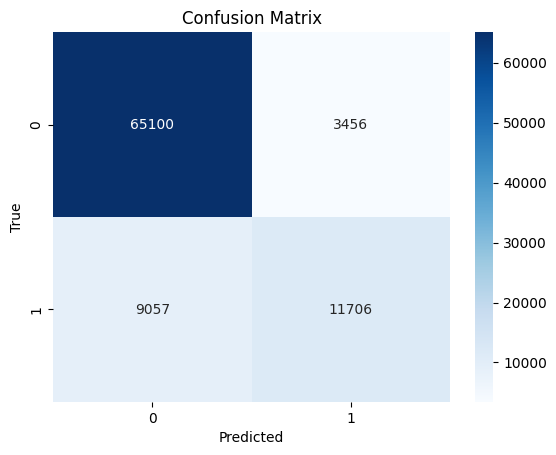

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     68556
           1       0.77      0.56      0.65     20763

    accuracy                           0.86     89319
   macro avg       0.82      0.76      0.78     89319
weighted avg       0.85      0.86      0.85     89319



In [13]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test)

## Data tune

[I 2025-05-05 15:49:13,804] A new study created in memory with name: no-name-c6d0367f-25ea-4f5b-9ae2-86b853698b14
[I 2025-05-05 15:49:20,636] Trial 0 finished with value: 0.5284142221627588 and parameters: {'n_estimators': 178, 'learning_rate': 0.05494043290301642, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6877725589260132, 'colsample_bytree': 0.9172306406684457, 'gamma': 1.1852273410807053, 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.5284142221627588.
[I 2025-05-05 15:49:25,644] Trial 1 finished with value: 0.7189961689122293 and parameters: {'n_estimators': 212, 'learning_rate': 0.20875431825823065, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8918808017169018, 'colsample_bytree': 0.8041383232996071, 'gamma': 3.103984882631909, 'threshold': 0.25}. Best is trial 1 with value: 0.7189961689122293.
[I 2025-05-05 15:49:39,330] Trial 2 finished with value: 0.663989145183175 and parameters: {'n_estimators': 444, 'learning_rate': 0.15629486946535137, 

Best trial:
FrozenTrial(number=1, state=1, values=[0.7189961689122293], datetime_start=datetime.datetime(2025, 5, 5, 15, 49, 20, 637478), datetime_complete=datetime.datetime(2025, 5, 5, 15, 49, 25, 643986), params={'n_estimators': 212, 'learning_rate': 0.20875431825823065, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8918808017169018, 'colsample_bytree': 0.8041383232996071, 'gamma': 3.103984882631909, 'threshold': 0.25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0,

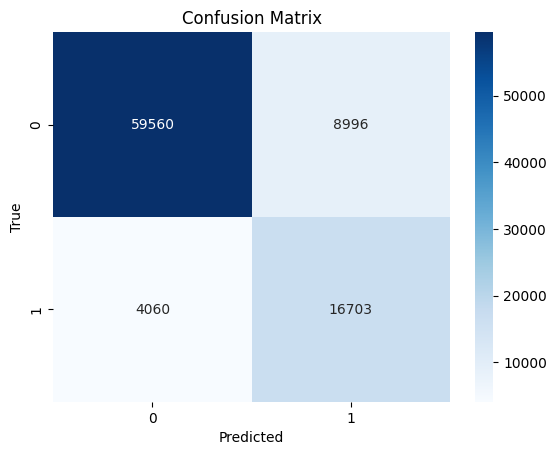

              precision    recall  f1-score   support

           0       0.94      0.87      0.90     68556
           1       0.65      0.80      0.72     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.84      0.81     89319
weighted avg       0.87      0.85      0.86     89319



In [14]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

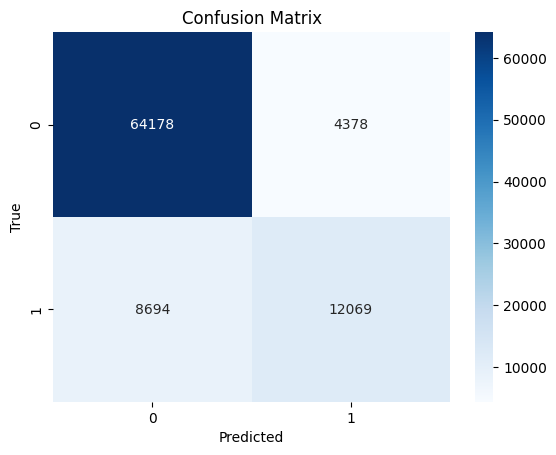

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     68556
           1       0.73      0.58      0.65     20763

    accuracy                           0.85     89319
   macro avg       0.81      0.76      0.78     89319
weighted avg       0.85      0.85      0.85     89319



In [15]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 15:54:34,396] A new study created in memory with name: no-name-7640b8b0-0c40-4a5b-8059-cd836b832da4
[I 2025-05-05 15:54:37,598] Trial 0 finished with value: 0.6795890079426196 and parameters: {'n_estimators': 313, 'learning_rate': 0.29057295514215825, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8288172518581545, 'colsample_bytree': 0.6966227968908989, 'gamma': 3.8487265931221644, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.6795890079426196.
[I 2025-05-05 15:54:39,971] Trial 1 finished with value: 0.5186175415715683 and parameters: {'n_estimators': 147, 'learning_rate': 0.2869205284862715, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9001322970588307, 'colsample_bytree': 0.7107040597879386, 'gamma': 2.4167974243245554, 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.6795890079426196.
[I 2025-05-05 15:54:43,578] Trial 2 finished with value: 0.566249728421118 and parameters: {'n_estimators': 161, 'learning_rate': 0.1716

Best trial:
FrozenTrial(number=41, state=1, values=[0.6949225658944825], datetime_start=datetime.datetime(2025, 5, 5, 15, 57, 43, 376387), datetime_complete=datetime.datetime(2025, 5, 5, 15, 57, 48, 814742), params={'n_estimators': 394, 'learning_rate': 0.07339200223160522, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.8130591739178537, 'colsample_bytree': 0.9419702249776923, 'gamma': 4.001561441413061, 'threshold': 0.30000000000000004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log

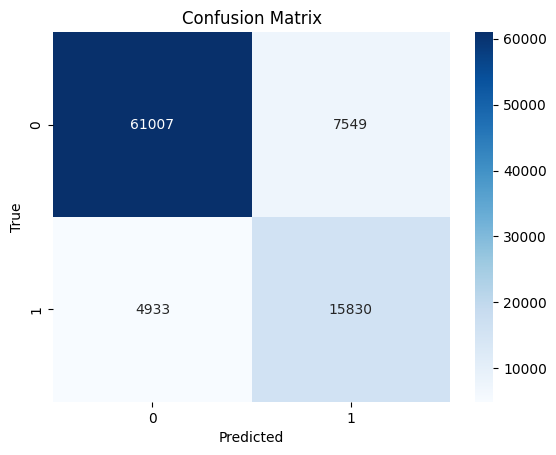

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     68556
           1       0.68      0.76      0.72     20763

    accuracy                           0.86     89319
   macro avg       0.80      0.83      0.81     89319
weighted avg       0.87      0.86      0.86     89319



In [16]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + scale_pos_weight

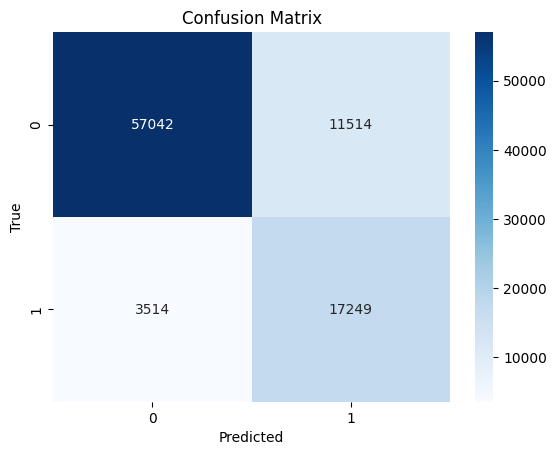

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     68556
           1       0.60      0.83      0.70     20763

    accuracy                           0.83     89319
   macro avg       0.77      0.83      0.79     89319
weighted avg       0.86      0.83      0.84     89319



In [17]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + Tune

[I 2025-05-05 15:58:41,497] A new study created in memory with name: no-name-8d533d34-30fc-4e74-bcbb-2786232aab48
[I 2025-05-05 15:58:54,670] Trial 0 finished with value: 0.7143861878077002 and parameters: {'n_estimators': 465, 'learning_rate': 0.1173484275618727, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.7974619775343919, 'colsample_bytree': 0.642284736106659, 'gamma': 1.0296124738853796, 'threshold': 0.5}. Best is trial 0 with value: 0.7143861878077002.
[I 2025-05-05 15:58:58,541] Trial 1 finished with value: 0.6559232241422351 and parameters: {'n_estimators': 288, 'learning_rate': 0.0947198074559417, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9243507508079518, 'colsample_bytree': 0.773849871529761, 'gamma': 0.4542379415045006, 'threshold': 0.85}. Best is trial 0 with value: 0.7143861878077002.
[I 2025-05-05 15:59:08,220] Trial 2 finished with value: 0.6801109150491556 and parameters: {'n_estimators': 138, 'learning_rate': 0.05049246250388717, 'max_depth': 10, 

Best trial:
FrozenTrial(number=27, state=1, values=[0.7208443271767809], datetime_start=datetime.datetime(2025, 5, 5, 16, 2, 46, 332570), datetime_complete=datetime.datetime(2025, 5, 5, 16, 2, 57, 254553), params={'n_estimators': 462, 'learning_rate': 0.09603474479687948, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.7133484357914908, 'colsample_bytree': 0.5616683448404672, 'gamma': 2.287511892159048, 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, s

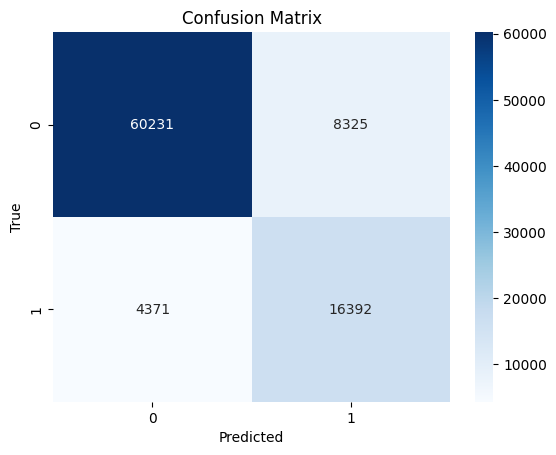

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     68556
           1       0.66      0.79      0.72     20763

    accuracy                           0.86     89319
   macro avg       0.80      0.83      0.81     89319
weighted avg       0.87      0.86      0.86     89319



In [18]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight)

## Data + scale_pos_weight + feature 

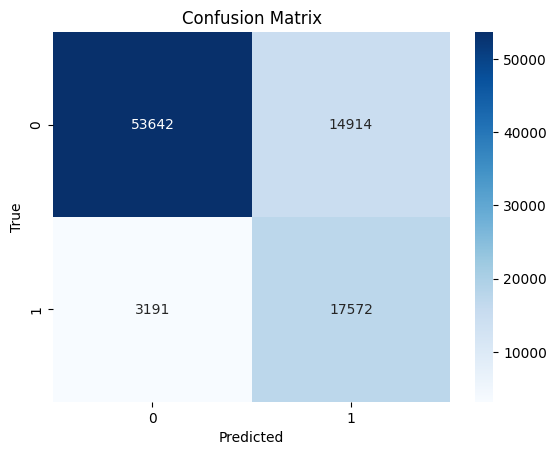

              precision    recall  f1-score   support

           0       0.94      0.78      0.86     68556
           1       0.54      0.85      0.66     20763

    accuracy                           0.80     89319
   macro avg       0.74      0.81      0.76     89319
weighted avg       0.85      0.80      0.81     89319



In [19]:
train_and_evaluate_xgb(X_train_scaled, y_train, X_test_scaled, y_test, scale_pos_weight=scale_pos_weight, top_features=top_features)

## Data + scale_pos_weight + feature + tune

[I 2025-05-05 16:06:02,777] A new study created in memory with name: no-name-0d1929de-a7a6-40f6-bc76-a91f82890ace
[I 2025-05-05 16:06:09,028] Trial 0 finished with value: 0.6512687397361869 and parameters: {'n_estimators': 284, 'learning_rate': 0.27177702671473514, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.618169957859386, 'colsample_bytree': 0.5671107942073916, 'gamma': 1.9770779254796818, 'threshold': 0.4}. Best is trial 0 with value: 0.6512687397361869.
[I 2025-05-05 16:06:12,970] Trial 1 finished with value: 0.6856619214048248 and parameters: {'n_estimators': 410, 'learning_rate': 0.22214299467757279, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.941008879839367, 'colsample_bytree': 0.5064767886403554, 'gamma': 1.5039006355626223, 'threshold': 0.65}. Best is trial 1 with value: 0.6856619214048248.
[I 2025-05-05 16:06:22,743] Trial 2 finished with value: 0.6787319777327464 and parameters: {'n_estimators': 395, 'learning_rate': 0.06320339138513979, 'max_depth': 9,

Best trial:
FrozenTrial(number=28, state=1, values=[0.6938693106619708], datetime_start=datetime.datetime(2025, 5, 5, 16, 8, 26, 754581), datetime_complete=datetime.datetime(2025, 5, 5, 16, 8, 29, 588716), params={'n_estimators': 149, 'learning_rate': 0.10662610718049997, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6736202256704882, 'colsample_bytree': 0.9385449837114319, 'gamma': 1.6660838229302009, 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=F

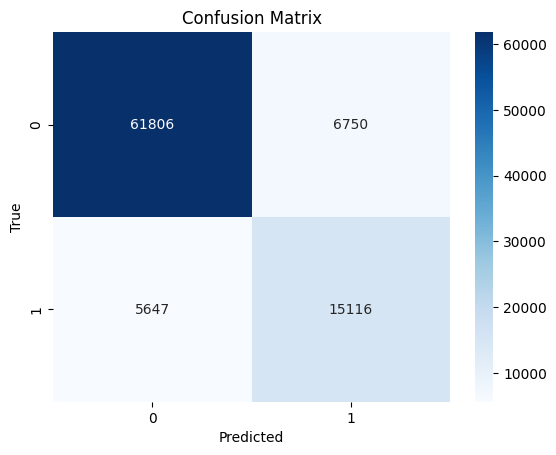

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     68556
           1       0.69      0.73      0.71     20763

    accuracy                           0.86     89319
   macro avg       0.80      0.81      0.81     89319
weighted avg       0.86      0.86      0.86     89319



In [20]:
optimize_and_train(X_train_scaled, y_train, X_test_scaled, y_test,scale_pos_weight=scale_pos_weight, top_features = top_features)

# SMOTE

In [21]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

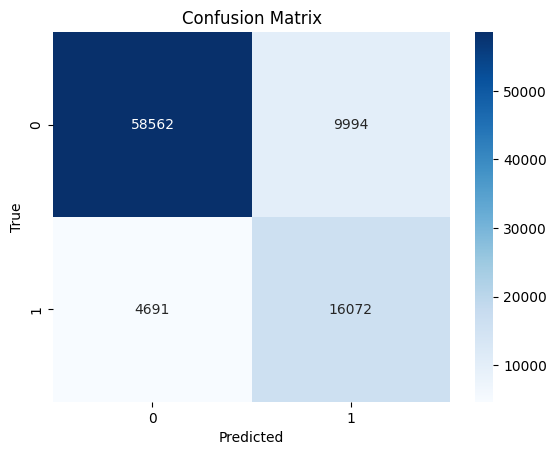

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     68556
           1       0.62      0.77      0.69     20763

    accuracy                           0.84     89319
   macro avg       0.77      0.81      0.79     89319
weighted avg       0.85      0.84      0.84     89319



In [22]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 16:09:50,007] A new study created in memory with name: no-name-467949dd-bd49-4ec2-b6bb-f2ab2e035178
[I 2025-05-05 16:10:03,921] Trial 0 finished with value: 0.6791770291657245 and parameters: {'n_estimators': 306, 'learning_rate': 0.09381600156608828, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.9372475805877868, 'colsample_bytree': 0.8898607162964344, 'gamma': 4.246909516303869, 'threshold': 0.65}. Best is trial 0 with value: 0.6791770291657245.
[I 2025-05-05 16:10:16,232] Trial 1 finished with value: 0.6461569329030747 and parameters: {'n_estimators': 387, 'learning_rate': 0.14972540122738776, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.9417110130166708, 'colsample_bytree': 0.9316248793654058, 'gamma': 2.50227805582992, 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.6791770291657245.
[I 2025-05-05 16:10:27,657] Trial 2 finished with value: 0.664254970822001 and parameters: {'n_estimators': 279, 'learning_rate': 0.014790465073124792,

Best trial:
FrozenTrial(number=36, state=1, values=[0.6968000000000001], datetime_start=datetime.datetime(2025, 5, 5, 16, 17, 0, 515613), datetime_complete=datetime.datetime(2025, 5, 5, 16, 17, 17, 436638), params={'n_estimators': 467, 'learning_rate': 0.017675178828393263, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.9983721245318481, 'colsample_bytree': 0.7454068371709591, 'gamma': 2.4011923332111667, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0

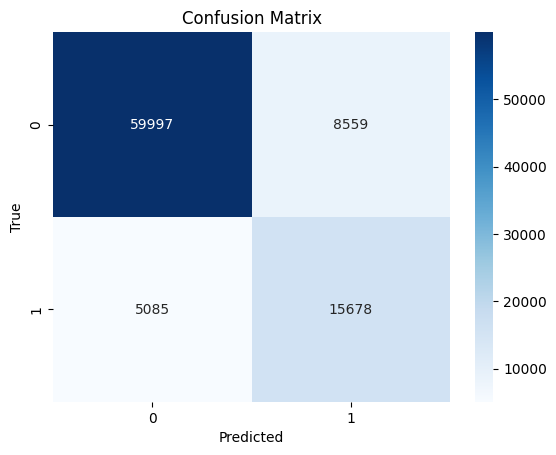

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     68556
           1       0.65      0.76      0.70     20763

    accuracy                           0.85     89319
   macro avg       0.78      0.82      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [23]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

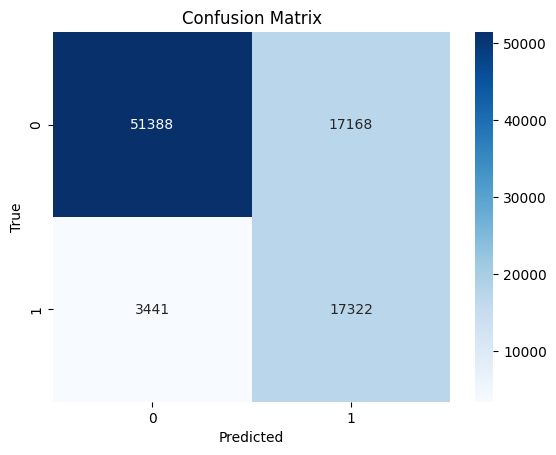

              precision    recall  f1-score   support

           0       0.94      0.75      0.83     68556
           1       0.50      0.83      0.63     20763

    accuracy                           0.77     89319
   macro avg       0.72      0.79      0.73     89319
weighted avg       0.84      0.77      0.79     89319



In [24]:
train_and_evaluate_xgb(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 16:21:15,776] A new study created in memory with name: no-name-46b09c0d-e82a-4081-938f-54bf60b7713e
[I 2025-05-05 16:21:24,566] Trial 0 finished with value: 0.5658564898788362 and parameters: {'n_estimators': 217, 'learning_rate': 0.2231095817117628, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6656395888959752, 'colsample_bytree': 0.6122861644822798, 'gamma': 0.8743697233183423, 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.5658564898788362.
[I 2025-05-05 16:21:26,949] Trial 1 finished with value: 0.5429361400884234 and parameters: {'n_estimators': 102, 'learning_rate': 0.20976314243391034, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6302051067405985, 'colsample_bytree': 0.9975123935633345, 'gamma': 4.983619148694588, 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.5658564898788362.
[I 2025-05-05 16:21:32,342] Trial 2 finished with value: 0.6065491813523309 and parameters: {'n_estimators': 301, 'learning_rate': 0.062

Best trial:
FrozenTrial(number=32, state=1, values=[0.6725013335440662], datetime_start=datetime.datetime(2025, 5, 5, 16, 25, 17, 558073), datetime_complete=datetime.datetime(2025, 5, 5, 16, 25, 21, 695075), params={'n_estimators': 103, 'learning_rate': 0.043407786145559527, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.843929228565602, 'colsample_bytree': 0.7431152389948624, 'gamma': 0.010344459371321862, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=

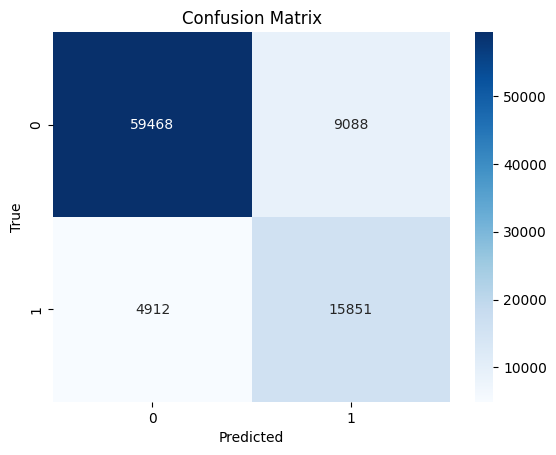

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     68556
           1       0.64      0.76      0.69     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.82      0.79     89319
weighted avg       0.86      0.84      0.85     89319



In [25]:
optimize_and_train(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [26]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

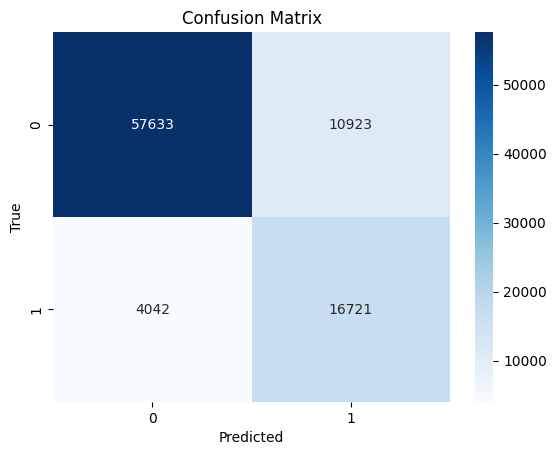

              precision    recall  f1-score   support

           0       0.93      0.84      0.89     68556
           1       0.60      0.81      0.69     20763

    accuracy                           0.83     89319
   macro avg       0.77      0.82      0.79     89319
weighted avg       0.86      0.83      0.84     89319



In [27]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 16:35:08,539] A new study created in memory with name: no-name-e5ba1a06-28d0-4449-874d-90ec75d8c1ee
[I 2025-05-05 16:35:13,416] Trial 0 finished with value: 0.6662981680353759 and parameters: {'n_estimators': 214, 'learning_rate': 0.20378160376188723, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9162427806457663, 'colsample_bytree': 0.5395107273964799, 'gamma': 4.329778080648508, 'threshold': 0.85}. Best is trial 0 with value: 0.6662981680353759.
[I 2025-05-05 16:35:20,653] Trial 1 finished with value: 0.6433594534860357 and parameters: {'n_estimators': 203, 'learning_rate': 0.2104105119999331, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.717615905853721, 'colsample_bytree': 0.8885415452942182, 'gamma': 0.8376943285045202, 'threshold': 0.1}. Best is trial 0 with value: 0.6662981680353759.
[I 2025-05-05 16:35:23,791] Trial 2 finished with value: 0.6811775839578484 and parameters: {'n_estimators': 126, 'learning_rate': 0.22178016767883535, 'max_depth': 3, 

Best trial:
FrozenTrial(number=39, state=1, values=[0.7029711411398609], datetime_start=datetime.datetime(2025, 5, 5, 16, 43, 17, 218409), datetime_complete=datetime.datetime(2025, 5, 5, 16, 43, 26, 464479), params={'n_estimators': 478, 'learning_rate': 0.17011413890996435, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.9626404737264209, 'colsample_bytree': 0.556727542114785, 'gamma': 4.386551541062054, 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0,

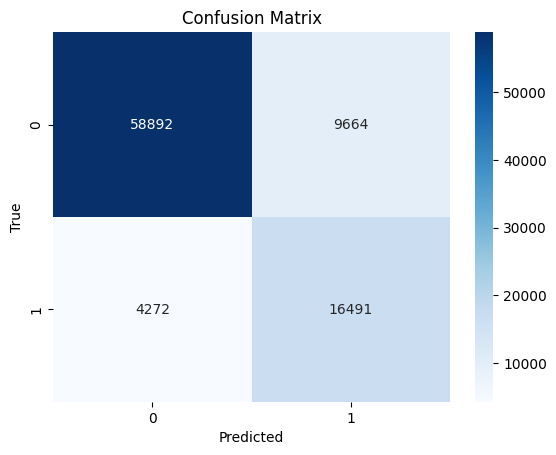

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     68556
           1       0.63      0.79      0.70     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.83      0.80     89319
weighted avg       0.86      0.84      0.85     89319



In [28]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

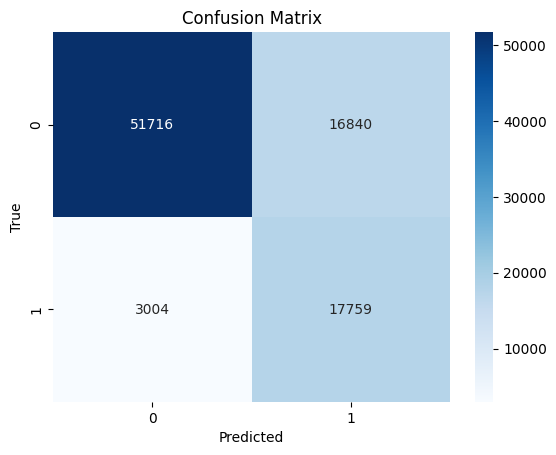

              precision    recall  f1-score   support

           0       0.95      0.75      0.84     68556
           1       0.51      0.86      0.64     20763

    accuracy                           0.78     89319
   macro avg       0.73      0.80      0.74     89319
weighted avg       0.84      0.78      0.79     89319



In [29]:
train_and_evaluate_xgb(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 16:45:10,541] A new study created in memory with name: no-name-8723c823-9d47-4073-b43d-61aa0eb2fd37
[I 2025-05-05 16:45:16,294] Trial 0 finished with value: 0.607445116131085 and parameters: {'n_estimators': 421, 'learning_rate': 0.2386440564853545, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9129714299218026, 'colsample_bytree': 0.8111203689633275, 'gamma': 3.2796060714912922, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.607445116131085.
[I 2025-05-05 16:45:21,380] Trial 1 finished with value: 0.646791049560813 and parameters: {'n_estimators': 226, 'learning_rate': 0.18418736134514932, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.5551020047749831, 'colsample_bytree': 0.6805747234498176, 'gamma': 0.519511920452006, 'threshold': 0.75}. Best is trial 1 with value: 0.646791049560813.
[I 2025-05-05 16:45:27,497] Trial 2 finished with value: 0.6213566375364129 and parameters: {'n_estimators': 446, 'learning_rate': 0.23941288831005608, 'ma

Best trial:
FrozenTrial(number=33, state=1, values=[0.6808501788536727], datetime_start=datetime.datetime(2025, 5, 5, 16, 48, 53, 460532), datetime_complete=datetime.datetime(2025, 5, 5, 16, 48, 58, 501581), params={'n_estimators': 119, 'learning_rate': 0.025633112625263636, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7304307105743635, 'colsample_bytree': 0.9488272996393677, 'gamma': 3.6722638320159495, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0

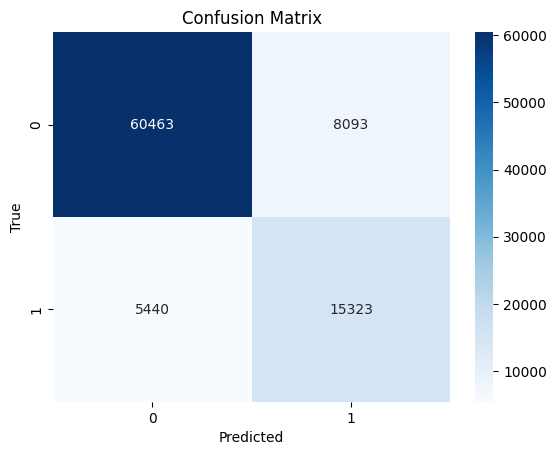

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     68556
           1       0.65      0.74      0.69     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.81      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [30]:
optimize_and_train(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)